In [1]:
# Installing all the packages you need.

import os

packages = ("numpy", "pandas", "matplotlib", "urllib", "tensorflow==1.6", "scikit-learn")

stream = os.popen("pip install " + "requests")
output = stream.read()
print(output)

In [0]:
# Importing necessary libraries

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import numpy as np
import os
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from tensorflow.python.framework import ops
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Reading the data from the file. For the file please refer to
# https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data#

df = pd.read_csv(os.path.join('sample_data','hpq.us.txt'), delimiter=',', usecols=['Date','Open','High','Low','Close'])

print('Data Loaded')

Data Loaded


In [8]:
# Exploring the data
#1. Sorting the data by date
df = df.sort_values('Date')

#2. Adding the mid-value for each entry
df["mid"] = (df['Low'] + df['High'])/2.0

#3. Number ofe entries
print("The dataset has {} entries".format(df.shape[0]))

#3. Printing the first 10 rows to check
df.head()

The dataset has 12075 entries


,Date,Open,High,Low,Close,mid
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,0.306270
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,0.311975
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,0.311905
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,0.313850
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,0.315765


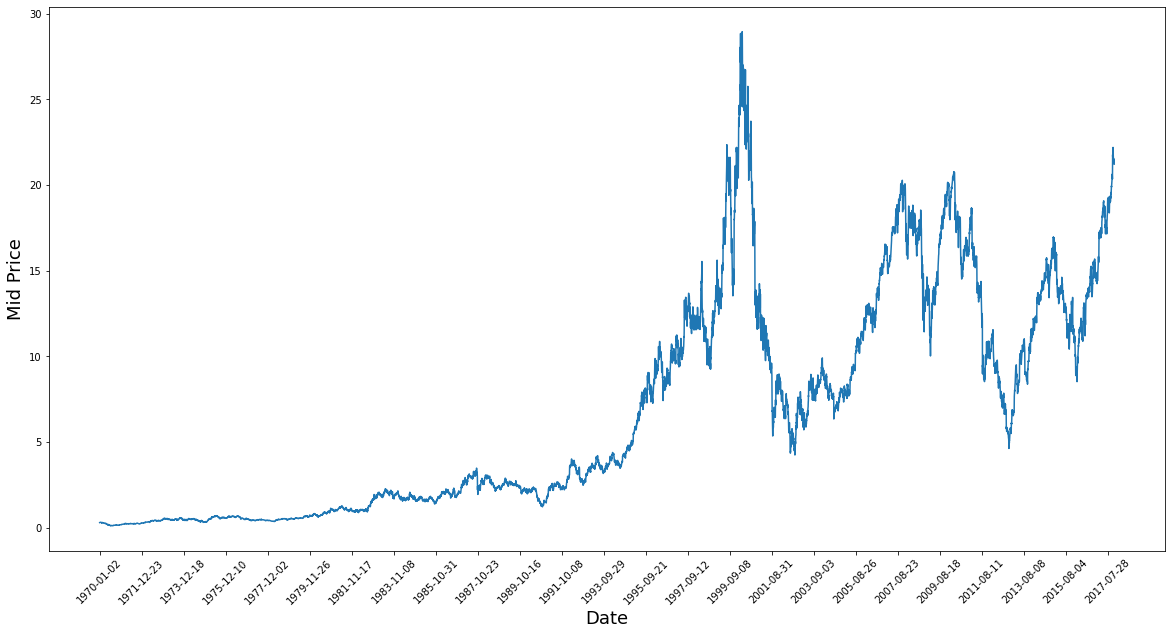

In [9]:
# Initial Data Visualtization
#1. Creating a figure with a specific size
plt.figure(figsize = (20,10))

#2. Plotting the data-points of mid-prices
plt.plot(range(df.shape[0]),df['mid'])

#3. Creating x-axis point names (dates) on the axis
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)

#4. Creating a label for the x axis
plt.xlabel('Date',fontsize=18)

#5. Creating a label for the y axis
plt.ylabel('Mid Price',fontsize=18)

#6. Showing the plot
plt.show()

In [0]:
# Splitting Data into train-test sets

train_data = df.loc[:,'mid'].values[:11000]
test_data = df.loc[:,'mid'].values[11000:]

In [0]:
# Normalizing the data so that the points lie within (0,1) range (windowed-normalization)

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

smoothing_window_size = 2500

for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
    
# Normalizing the last bit of remaining data

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data

EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [31]:
# One-Step Ahead Prediction
# Predicting the value at time t based on previous (windo-sized) number of points (Simple Averaging)

window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']
    
    # Calculating the mean and using it as the predicted value
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    
    # Calculating the mean squared error based on the difference between
    # the actual value and the predicted one
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


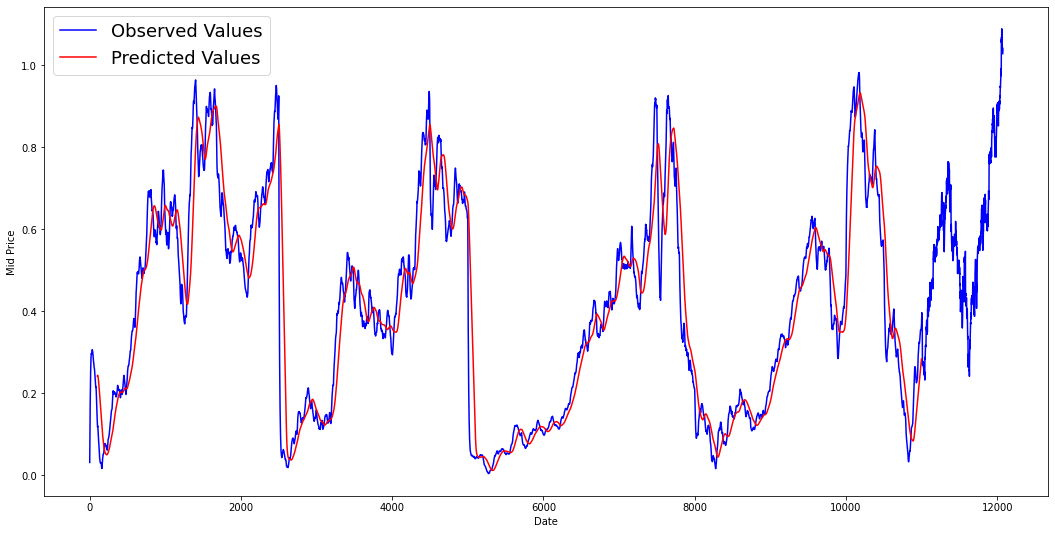

In [32]:
# Plotting the result from simple average prediction

#1. Creating a figure with a specific size
plt.figure(figsize = (18,9))

#2. Plotting the mid-prices from the observed values
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Observed Values')

#3. Plotting the result from prediction
plt.plot(range(window_size,N),std_avg_predictions, color='r', label='Predicted Values')

#4. Creating a label for the x axis
plt.xlabel('Date')

#5. Creating a label for the y axis
plt.ylabel('Mid Price')

#6. Creating a legend at the corner of the figure
plt.legend(fontsize=18)

#7. Showing the plot on the screen
plt.show()

In [33]:
# Exponential Moving Average Prediction

window_size = 100
N = train_data.size

run_avg_predictions = []
# run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    
    # Calculating the moving average and using it as a prediction
    run_avg_predictions.append(running_mean)
    
    # Calculating the mean squared error based on the difference between
    # the actual value and the predicted one
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
#     run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


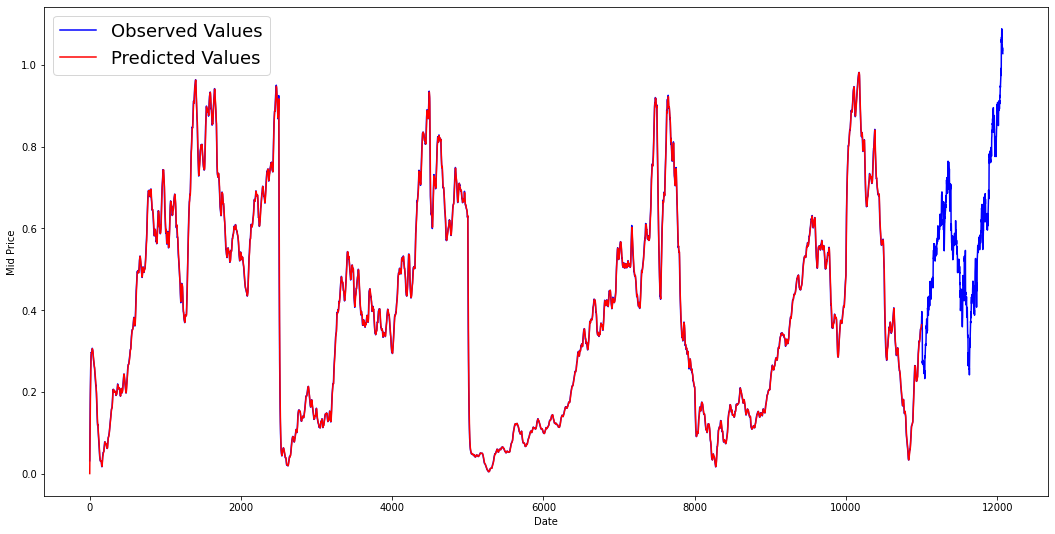

In [35]:
# Plotting the result from moving average prediction

#1. Creating a figure with a specific size
plt.figure(figsize = (18,9))

#2. Plotting the mid-prices from the observed values
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='Observed Values')

#3. Plotting the result from prediction
plt.plot(range(0,N),run_avg_predictions,color='red', label='Predicted Values')

#4. Creating a label for the x axis
plt.xlabel('Date')

#5. Creating a label for the y axis
plt.ylabel('Mid Price')

#6. Creating a legend at the corner of the figure
plt.legend(fontsize=18)

#7. Showing the plot on the screen
plt.show()

In [36]:
# Creating a class of data generator with data augmentation
# along with unrolling and batching (tunable in the __init__ magic function) 

class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.03143791 0.6904868  0.82829314 0.32585657 0.11600105]

	Output: [0.08698314 0.6848606  0.833369   0.33078218 0.11946969]


Unrolled index 1
	Inputs:  [0.06067836 0.6890754  0.8325337  0.32857886 0.11785509]

	Output: [0.11098009 0.68685144 0.833369   0.33421066 0.12192084]


Unrolled index 2
	Inputs:  [0.08698314 0.68685144 0.8329321  0.33078218 0.11946969]

	Output: [0.15261841 0.6826334  0.8329321  0.33650374 0.12230608]


Unrolled index 3
	Inputs:  [0.11098009 0.6858036  0.83294916 0.33219692 0.12106793]

	Output: [0.1887914  0.6836884  0.83387965 0.33355275 0.12106793]


Unrolled index 4
	Inputs:  [0.132895   0.6848606  0.833369   0.33355275 0.12158521]

	Output: [0.17132245 0.6826334  0.83383167 0.34456673 0.12192084]


In [0]:
# Defining the hyperparameters of the model

# Data dimensionality which is 1 in our case.
D = 1

# Number of time steps to look into the future (unrolling)
num_unrollings = 50

# Number of samples in a batch
batch_size = 500

# Number of hidden nodes in each layer of the deep LSTM network
num_nodes = [200,200,150]

# Number of network layers
n_layers = len(num_nodes)

# Dropout prob.
dropout = 0.2 # dropout amount

# This is important in case you run this multiple times
ops.reset_default_graph()

In [0]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
tf.compat.v1.disable_eager_execution()
for ui in range(num_unrollings):
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,D], name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [57]:
# Creating LSTM cells with corresponding number of nodes and layers

lstm_cells = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.keras.initializers.GlorotNormal()
                           )
 for li in range(n_layers)]

# Implementing the dropout
drop_lstm_cells = [tf.compat.v1.nn.rnn_cell.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]


# Creating a multi-cell RNN
drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)

w = tf.compat.v1.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.keras.initializers.GlorotNormal())
b = tf.compat.v1.get_variable('b',initializer=tf.compat.v1.random_uniform([1],-0.1,0.1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM

c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.compat.v1.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.compat.v1.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [66]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
#The mean error of each batch is calculated and then the sum of that over all unrolled steps are calculated.

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.compat.v1.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.compat.v1.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.compat.v1.assign(global_step,global_step + 1)
tf_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.compat.v1.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimization process

print('TF Optimization operations')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(zip(gradients, v))


print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [69]:
# Defining the TF functions that are related to the prediction

print('Defining prediction related TF functions')

sample_inputs = tf.compat.v1.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]

for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.compat.v1.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.compat.v1.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.compat.v1.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.compat.v1.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.compat.v1.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.compat.v1.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [72]:
# Running the LSTM network (training, validation, testing)

epochs = 30

# Interval you make test predictions
valid_summary = 1

# Number of steps you continously predict for
n_predict_once = 50

# Full length of the training data
train_seq_length = train_data.size

# List to hold all train losses
train_mse_ot = []

# List to hold all test losses
test_mse_ot = []

# List to hold all predictions
predictions_over_time = []

# Setting up the tensorflow session
session = tf.compat.v1.InteractiveSession()

# Initializing variables
tf.compat.v1.global_variables_initializer().run()

# Learning rate decay setup
loss_nondecrease_count = 0

# Decrease the learning rate after the test loss has remained the same for this many steps
loss_nondecrease_threshold = 2 

print('Initialized')
average_loss = 0

# Defining the data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

        # The average loss
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)
        
        # reset loss
        average_loss = 0 

        predictions_seq = []

        mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
    for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
            current_price = all_mid_data[tr_i]
            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
            _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

            pred = session.run(sample_prediction,feed_dict=feed_dict)

            our_predictions.append(np.asscalar(pred))

            feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

            if (ep+1)-valid_summary==0:
                # Only calculate x_axis values in the first validation epoch
                x_axis.append(w_i+pred_i)

            mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
            x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
        if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
        predictions_over_time.append(predictions_seq)
        print('\tFinished Predictions')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 2.656159


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.04469
	Finished Predictions
	Test MSE: 0.02431
	Finished Predictions
	Test MSE: 0.02260
	Finished Predictions
	Test MSE: 0.02225
	Finished Predictions
	Test MSE: 0.02429
	Finished Predictions
	Test MSE: 0.02806
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.02931
	Finished Predictions
	Test MSE: 0.03621
	Finished Predictions
	Test MSE: 0.04162
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.04399
	Finished Predictions
	Test MSE: 0.04623
	Finished Predictions
	Test MSE: 0.04464
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.04656
	Finished Predictions
	Test MSE: 0.04385
	Finished Predictions
	Test MSE: 0.04201
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.04087
	Finished Predictions
	Test MSE: 0.04146
	Finished Predictions
	Test MSE: 0.04200
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.04136
	Finished Predictions
	Test MSE: 0.04400
	Finished Predictions
Average loss at

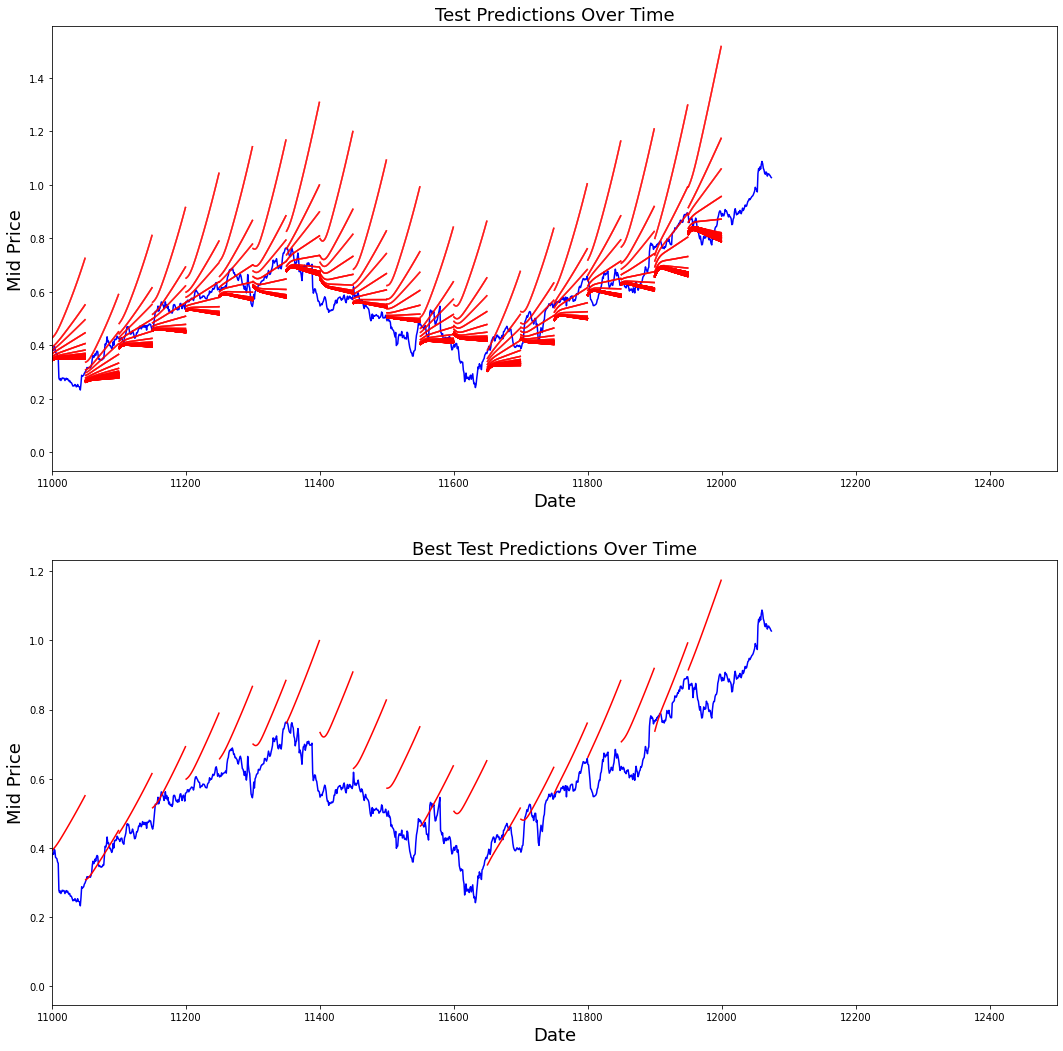

In [73]:
# Visulisation of the predictions

# Change the number below to the epoc you got the best results from
best_prediction_epoch = 28

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()